In [1]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from  torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torchvision
from sklearn.utils import shuffle
import os

c:\Users\junio\anaconda3\envs\TorchEnv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def setup_dataset(traindir:str, validationdir:str, testdir:str=None, dim=224, batch: int=16) -> tuple:
    class_names = sorted(os.listdir(traindir))
    # Assert that class names are names in this scheme: 00_class, 01_class, ...
    for c in class_names:
        assert len(
            c.split("_")[0]) == 2, "Class names must start with double digit numbers followed by an underscore"
    #transformations
    train_transform = transforms.Compose([transforms.Resize((dim,dim)),                                
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(10),
                                        transforms.ToTensor(),                                
                                        transforms.Normalize(
                                            mean=[0.485, 0.456, 0.406],
                                            std=[0.229, 0.224, 0.225],
        ),
                                        ])

    img_transforms = transforms.Compose([transforms.Resize((dim,dim)),
                                        transforms.ToTensor(),                                
                                        transforms.Normalize(
                                            mean=[0.485, 0.456, 0.406],
                                            std=[0.229, 0.224, 0.225],
        ),
                                        ])
                            
    #datasets
    train_data = datasets.ImageFolder(os.path.normpath(traindir),transform=train_transform)
    valid_data = datasets.ImageFolder(os.path.normpath(validationdir),transform=img_transforms)
    if testdir:
        test_data = datasets.ImageFolder(os.path.normpath(testdir),transform=img_transforms) 
    else:
        test_data = valid_data

    #dataloader
    trainset = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size=batch, drop_last=True)
    validset = torch.utils.data.DataLoader(valid_data, shuffle = True, batch_size=batch, drop_last=True)
    testset = torch.utils.data.DataLoader(test_data, shuffle = True, batch_size=batch, drop_last=True)

    return trainset, validset, testset, class_names

In [11]:
traindir = "../dataset/casting_data/train"  
validdir = "../dataset/casting_data/valid"
testdir = "../dataset/casting_512x512" # if None, testset = validset

# Hyperparameters
param_args = {'num_classes': 2,    
                'Batch_Size': 8,
                'dim':24, # dim*dim matrix for resizing method
                'Learning_Rate': 0.01,       
                'Epochs': 10 } 

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
train_loader, valid_loader, test_loader, label = setup_dataset(traindir, validdir, testdir, param_args['dim'],param_args['Batch_Size'])

##Data Visualizieren##

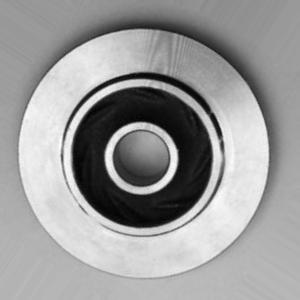

In [4]:
import os 
from PIL import Image

Image.open(os.path.join(traindir,"00_ok_front/cast_ok_0_1.jpeg"))


#**Transfer learning mit Resnet50** 

In [12]:
from torchvision.models import resnet50
Model = resnet50(pretrained=True).to(device)
print(Model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
from torch import nn

for prm in Model.parameters():
    prm.requires_grad = False

# output layer
Model.fc = nn.Sequential(nn.Linear(Model.fc.in_features, 1))
Model.to(device)
print(Model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:

def train(trainset, m_device, m_model, m_optimizer, m_loss, m_epoch:int, train_loss_values:list,train_acc_values:list, log_interval=200)->None:
    # Set model to training mode
    m_model.train()
    train_loss,correct = 0,0

    for batch_idx, (X_train, y_train) in enumerate(trainset):


        X_train = X_train.to(m_device)
        y_train = y_train.to(m_device)

        # Forward Propagation:  compute predicted outputs by passing inputs to the model
        y_predicted = torch.sigmoid(m_model(X_train))
        # Zero gradient buffers: clear the gradients of all optimized variables
        m_optimizer.zero_grad() 

        # Calculate loss
        loss = m_loss(y_predicted, y_train.float().unsqueeze(1))

        # Backpropagate: compute gradient of the loss with respect to m_model parameters
        loss.backward()
        
        # Update weights: perform a single optimization step (parameter update)
        m_optimizer.step()
        train_loss += loss.item()  
        pred = y_predicted.data.max(1)[1]
        correct += (pred == y_train).float().sum()
 
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                m_epoch, batch_idx * len(X_train), len(trainset.dataset),
                100. * batch_idx / len(trainset), loss.item()))
    
    # calculate average loss over an epoch            
    train_loss /= len(trainset)
    train_loss_values.append(train_loss)    
    
    accuracy = 100 * correct / len(trainset.dataset)
    train_acc_values.append(accuracy.item())

    print(f'Train Epoch: {m_epoch}\nTrain set: Average loss: {loss}, Accuracy: {correct}/{len(trainset.dataset)} --> {round(accuracy.item(),2)}%\n')

In [8]:
def validate(valset, m_device, m_model,m_loss, m_epoch, val_loss_values:list, val_acc_values:list)->None:
    m_model.eval()
    val_loss, correct = 0, 0
    
    for X_val, y_val in valset:

        X_val = X_val.to(m_device)
        y_val = y_val.to(m_device)

        # Forward Propagation:  compute predicted outputs by passing inputs to the model
        y_predicted = torch.sigmoid(m_model(X_val))
        
        # Calculate loss
        loss = m_loss(y_predicted, y_val.float().unsqueeze(1))
        val_loss += loss.item()  
        
        pred = y_predicted.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(y_val.data).cpu().sum()

    val_loss /= len(valset)
    val_loss_values.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(valset.dataset)
    val_acc_values.append(accuracy)
    
    print(f'Val Epoch: {m_epoch}\nValidation set: Average loss: {loss}, Accuracy: {correct}/{len(valset.dataset)} --> {round(accuracy.item(),2)}%\n')

In [14]:
import torch
import logging
import os
import matplotlib.pyplot as plt
import itertools
import json
from textwrap import wrap
import numpy as np

def save_model(torch_model, path:str = "./binary_model.pth")->None:
    torch.save(torch_model, path)
    logging.info("model saved to {}".format(path))

def save_graph(epochs:int, attr:list, val_attr:list, title:str, type:str="acc")->None:
    label1 = "train_" + type
    label2 = "val_" + type
    plt.figure(figsize=(5,5))
    plt.plot(np.arange(epochs), attr, 'r', label= label1)
    plt.plot(np.arange(epochs), val_attr, 'b', label = label2)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Values')
    plt.legend()
    plt.show()
    plt.savefig(title + ".png")
    plt.close()
    save_path = os.path.join(os.getcwd(), title + ".png")
    print(f"Saved {title} graph to: {save_path}.png")

def save_confusion_matrix(cm_input, labels:list, title='Confusion matrix', cmap='Blues'):
    """
    Create a confusion matrix plot
    :param cm_input: np.array of tps, tns, fps and fns
    :param labels: list of class names
    :param title: title of plot
    :param cmap: colormap of confusion matrix
    :return:
    """
    font_size = 14 + len(labels)
    if np.max(cm_input) > 1:
        cm_input = cm_input.astype(int)
    if isinstance(labels[0], str):
        ['\n'.join(wrap(label, 20, break_long_words=False)) for label in labels]
    plt.figure(figsize=(2 * len(labels), 2 * len(labels)))
    plt.imshow(cm_input, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=font_size)

    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45, rotation_mode="anchor", ha="right", fontsize=font_size)
    plt.yticks(tick_marks, labels, fontsize=font_size)

    thresh = np.max(cm_input) / 2
    for i, j in itertools.product(range(cm_input.shape[0]), range(cm_input.shape[1])):
            plt.text(j, i, "{:d}".format(cm_input[i, j]), horizontalalignment="center",
                     color="white" if cm_input[i, j] > thresh else "black", fontsize=font_size * 2 / 3)
    plt.ylabel('True label', fontsize=font_size)
    plt.xlabel('Predicted label', fontsize=font_size)
    plt.tight_layout()
    plt.savefig(title + ".png", bbox_inches='tight')
    plt.close
    save_path = os.path.join(os.getcwd(), title + ".png")
    print(f"Saved {title} graph to: {save_path}.png")

def save_classification_report(m_report:dict, title="classification_report")->None:
    save_path = os.path.join(os.getcwd(), title + ".json")
    with open(title + ".json", "w+") as f:
        json.dump(m_report, f, indent=2)
    print(f"Classification report saved in: {save_path}")

Train Epoch: 0 [0/6633 (0%)]	Loss: 0.801646
Train Epoch: 0 [1600/6633 (24%)]	Loss: 0.293134
Train Epoch: 0 [3200/6633 (48%)]	Loss: 1.399952
Train Epoch: 0 [4800/6633 (72%)]	Loss: 4.360925
Train Epoch: 0 [6400/6633 (97%)]	Loss: 1.702942
Train Epoch: 0
Train set: Average loss: 1.1151081323623657, Accuracy: 2874.0/6633 --> 43.33%

Val Epoch: 0
Validation set: Average loss: 14.49456787109375, Accuracy: 260/715 --> 36.36%

Train Epoch: 1 [0/6633 (0%)]	Loss: 0.983128
Train Epoch: 1 [1600/6633 (24%)]	Loss: 0.039928
Train Epoch: 1 [3200/6633 (48%)]	Loss: 1.645259
Train Epoch: 1 [4800/6633 (72%)]	Loss: 1.436750
Train Epoch: 1 [6400/6633 (97%)]	Loss: 0.927238
Train Epoch: 1
Train set: Average loss: 1.761345624923706, Accuracy: 2874.0/6633 --> 43.33%

Val Epoch: 1
Validation set: Average loss: 0.7923811078071594, Accuracy: 261/715 --> 36.5%

Train Epoch: 2 [0/6633 (0%)]	Loss: 1.220613
Train Epoch: 2 [1600/6633 (24%)]	Loss: 0.829143
Train Epoch: 2 [3200/6633 (48%)]	Loss: 1.748021
Train Epoch: 2 [4

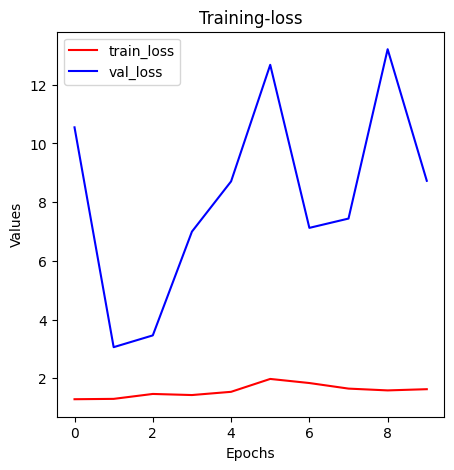

Saved Training-loss graph to: c:\Users\junio\OneDrive\Desktop\Studium\Neuronale Nezte\Hausarbeit2\Training-loss.png.png


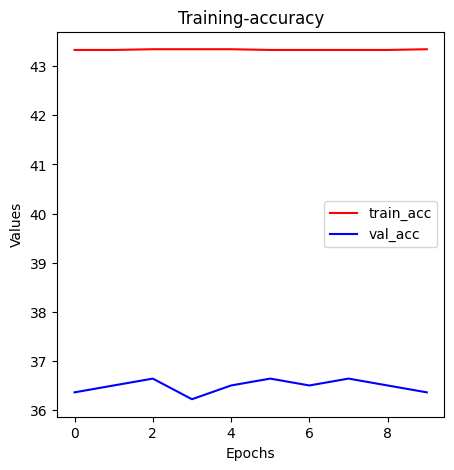

Saved Training-accuracy graph to: c:\Users\junio\OneDrive\Desktop\Studium\Neuronale Nezte\Hausarbeit2\Training-accuracy.png.png
Confusion matrix [[446  72]
 [522 256]]
Saved Confusion matrix graph to: c:\Users\junio\OneDrive\Desktop\Studium\Neuronale Nezte\Hausarbeit2\Confusion matrix.png.png


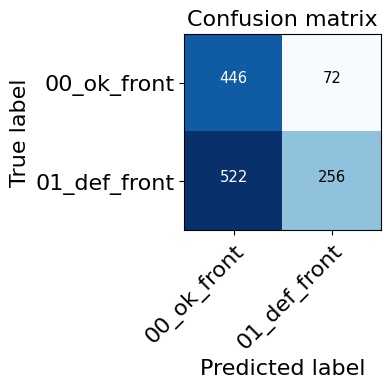

In [15]:
import time
import torch.optim as optim
from torchmetrics.classification import BinaryConfusionMatrix

optimizer =  optim.Adam(Model.parameters(), lr=param_args['Learning_Rate'])
loss = nn.BCELoss() 
train_loss,val_loss, train_acc, val_acc = list(), list(), list(), list()
start = time.time()

for epoch in range(param_args['Epochs']):
    train(trainset=train_loader, m_device= device, m_model=Model, 
            m_optimizer=optimizer, m_loss=loss, m_epoch=epoch,
            train_loss_values=train_loss,train_acc_values=train_acc)
    validate(valset=valid_loader, m_device=device, m_model=Model,
                m_loss=loss, m_epoch=epoch,
                val_loss_values=val_loss,val_acc_values=val_acc)
    
elapsed_time = time.time() - start
hours = elapsed_time // 3600
rest = elapsed_time % hours if hours else elapsed_time
minutes = rest // 60
seconds = round(rest % 60)
print(" ")
print("training duration: {} sec -> {}h:{}min:{}sec".format(elapsed_time, int(hours),int(minutes),int(seconds)))

save_model(Model)
print(" ")
save_graph(param_args['Epochs'], train_loss, val_loss, title='Training-loss', type="loss")
save_graph(param_args['Epochs'], train_acc, val_acc, title='Training-accuracy')

# confusion matrix
bcm = BinaryConfusionMatrix()
Model.eval()
with torch.no_grad():
        for xb_test,yb_test  in test_loader:
                y_test_pred = torch.sigmoid(Model(xb_test.to(device)))
                y_pred_tag = torch.round(y_test_pred).squeeze()
                bcm.update(y_pred_tag, yb_test)

cf_matrix = bcm.compute().detach().numpy()
print(f"Confusion matrix {cf_matrix}")
save_confusion_matrix(cf_matrix, label)